In [1]:
from sklearn.datasets import make_classification
from matplotlib import pyplot as plt
import seaborn as sns
import numpy as np
import pandas as pd
from scipy import stats
import matplotlib.pyplot as plt
import random
import time



/usr/local/lib/python3.6/dist-packages/statsmodels/tools/_testing.py:19: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm


In [2]:
#User input for algorithm:
#for synthetic data/potentially for regular datasets user can set the total subgroups/centroids
centroids = input("Enter number of centroids: ")
groups = input("Enter number of groups: ")

Enter number of centroids: 10
Enter number of groups: 5


In [3]:
#calculates euclidean distance between points
def calc_dist(x,y,x_ref,y_ref):
  return np.sqrt((((x-x_ref)**2)+((y-y_ref)**2))) 


In [4]:
#calculuates loss by inputting euclidean distance into sigmoid function
def calc_loss(x,y,x_ref,y_ref):
    # calculate Euclidean distance btw person & centroid
    distance = calc_dist(x,y,x_ref,y_ref)
    # refer to the above distance function to determine individual loss
    loss = 1/(1+ np.exp(-1*(distance))) #converts distances to probability distribution
    #return loss
    return loss

In [5]:
#this function calculates the summation of all the individual losses within each cluster for minimizing the objective function
def sum_loss(df, centroids, subgroup_loss):
  #total datapoints
  tot_len = 0
  #sum of all individual losses between clusters
  loss_sum = 0
  clusters = []
  max_val = df['min_loss'].max()
  min_val = df['min_loss'].min()

  for i in centroids.keys():
    temp = df[df['min_centr']==i]
    temp = temp.reset_index()
    clusters.append(temp)
    tot_len += len(temp)
    loss_sum += temp['min_loss'].sum()
  # print('indiv loss ', (loss_sum/tot_len))
  # print('subgroup loss: ', subgroup_loss)
  tot_loss = .8*(loss_sum/tot_len)
  tot_loss += ((1-.8)*subgroup_loss)
  print('indiv loss ', tot_loss)
  print('subgroup loss: ', subgroup_loss)
  return .1*tot_loss


In [6]:
def assign_cluster(df, centroids):
  start = time.time()
  for i in centroids.keys():
    #loss based on euclidean distance for each individual point compared to both centroids
    #stored in dataframe
    df['loss_from_{}'.format(i)] = calc_loss(df['x_coord'], df['y_coord'], centroids[i][0], centroids[i][1])
    df['dist_from_{}'.format(i)] = calc_dist(df['x_coord'], df['y_coord'], centroids[i][0], centroids[i][1])
  centroid_dist_col = ['loss_from_{}'.format(i) for i in centroids.keys()]
  #df column which holds the value of the closest centroid for each point
  df['min_centr'] = df.loc[:, centroid_dist_col].idxmin(axis=1)
  df['min_centr'] = df['min_centr'].map(lambda x: int(x.lstrip('loss_from_')))
  #value of loss calculated from sigmoid in calc_loss function for individual loss
  df['min_loss'] = df[['loss_from_{}'.format(i) for i in centroids.keys()]].min(axis=1)
  end = time.time()
  print('Time elapsed Assignment Step: ', end - start)
  for i in range(len(centroids)):
    del df['loss_from_{}'.format(i)]
    lst = df['min_centr'].unique()
    if i not in lst:
      del df['dist_from_{}'.format(i)]
  return df

In [7]:
# this function compares the loss between two groups at a certain percentile level
def compare_loss(group1,group2,percentile):
    select_group = [group1, group2]
    percentile_loss = []
    for s in select_group:
        s.sort_values(by=['min_loss'])
        subgroup = [s['min_loss']] # subset the two different groups of interest
        loss_p = stats.scoreatpercentile(subgroup, percentile) # find the level of loss at given percentile
        percentile_loss.append(loss_p) # load list with loss    
    difference = percentile_loss[0]-percentile_loss[1] # find difference between two @ percentile
    return np.abs(difference)

In [8]:
#calculates gradient for clusters
def update_weights(clust, lr, centr, df):
  #total number of points in cluster 0 (points nearest to centroid 0)
  new_centr_x, new_centr_y = centr[0], centr[1]
  #calculate partial derivatives of euclidean distance functions
  x = clust['x_coord']
  y = clust['y_coord']
  center = clust['min_centr']
  distance = clust['dist_from_{}'.format(int(center))]
  grad_x = (np.exp(-1*distance) * (x - centr[0])) / (1 + np.exp(-1*distance)*distance)
  grad_y = (np.exp(-1*distance) * (y - centr[1])) / (1 + np.exp(-1*distance)*distance)
  # new_centr_x += (grad_x) * lr
  # new_centr_y += (grad_y) * lr
  # print('new loss: *** ', calc_loss(x,y,new_centr_x, new_centr_y))
  new_centr_x = (grad_x) 
  new_centr_y = (grad_y) 
  return (new_centr_x, new_centr_y)

In [9]:
def mini_batch(df, b, count, temp_centroids, centroids, groups, cdf1,cdf2):
  # samp = groups[cdf1].sample(n=b, random_state=1)
  samp = df.sample(n=b, random_state=1)
  samp = samp.reset_index()
  start = time.time()
  sum_x = {}
  for i in centroids.keys():
    sum_x[i] = 0

  sum_y = {}
  for i in centroids.keys():
    sum_y[i] = 0
  # print(samp['min_centr'])
  for i in centroids.keys():
    count[i] = 0
  for s in range(len(samp)):
    clust = samp.iloc[s]['min_centr']
    clust = int(clust)
    count[clust]+=1
    lr = 1/count[clust]
    temp = update_weights(samp.iloc[s], lr, temp_centroids[clust], df)
    sum_x[clust] += temp[0]
    sum_y[clust] += temp[1]
  for i in range(len(temp_centroids)):
    if sum_x[i] != 0 and sum_y[i] != 0:
      temp_centroids[i] = (-1*lr*(sum_x[i]/count[i]), -1*lr*(sum_y[i]/count[i]))
  end = time.time()
  print('Time elapsed Batch Step: ', end - start)
  return temp_centroids

In [10]:
#updates centroid locations based on gradient descent and loss constraint
def update(perc, centroids, df, subgroup_loss, loss, groups, cdf1, cdf2):
  tot_loss_lst = []
  prev_centr = {}
  for i in centroids.keys():
    prev_centr[i] = 0

  b = 32
  max_iter = 50
  iter_num = 0
  conv = 3
  j = 0
  tot_loss_lst.append(loss)
  #set temporary centroids for assignment
  temp_centroids = {}
  for i in centroids.keys():
    temp_centroids[i] = centroids[i]
  count = {}
  #beginning of updating 
  # while subgroup_loss > L and iter_num < max_iter:
  while prev_centr != centroids:
    print('XXX')
    start = time.time()
    old_loss = loss
    #set up for mini batch gradient descent
    temp_centroids = mini_batch(df, b, count, temp_centroids, centroids, groups, cdf1, cdf2)
    #testing to see if new centroid locations improve summation of individual loss
    temp_df = assign_cluster(df, temp_centroids)
    groups = compute_groups(temp_df)
    cdf1, cdf2 = compute_cdf(groups)
    temp_subgroup_loss = compare_loss(groups[cdf1], groups[cdf2], 50)   
    temp_loss = sum_loss(temp_df, temp_centroids, temp_subgroup_loss)
    iter_num += 1
    print('iteration number: ', iter_num)
    print('old loss: ', old_loss)
    print('temp loss: ', temp_loss)
    if old_loss != temp_loss and j < conv:
      #only change centroid locations if it improves subgroup loss
      if old_loss > temp_loss:
        subgroup_loss = temp_subgroup_loss
        loss = temp_loss
        df = temp_df
        groups = compute_groups(df)
        compute_cdf_graph(groups)
        for i in prev_centr.keys():
          prev_centr[i] = centroids[i]
        for i in centroids.keys():
          centroids[i] = temp_centroids[i]
        print('c ', centroids)
        fig = plt.figure(figsize=(5,5))
        ax = sns.scatterplot(X[:,0],X[:,1],hue=y)

        for i in centroids.keys():
          plt.scatter(centroids[i][0], centroids[i][1], color=color_map[i])

        plt.xlim(-25, 25)
        plt.ylim(-25, 25)
        ax.set_title("Synthetic Data")
        plt.show()
      else:
        j += 1
      # loss = sum_loss(temp_df, centroids, subgroup_loss)
      tot_loss_lst.append(loss)
    else:
      end = time.time()
      print('Time elapsed End of Update Step: ', end - start)
      plt.title('Cost per iteration')
      plt.plot(tot_loss_lst)
      plt.show()
      return centroids
  plt.title('Cost per iteration')
  plt.plot(tot_loss_lst)
  plt.show()
  print('Reached max iterations')
  print('prev centroids: ', prev_centr)
  return centroids    

In [11]:
def compute_cdf(groups):
  lst = []
  perc = []
  for group in groups:
    sorted_data = group.sort_values(by=['min_loss'])
    sorted_len = len(sorted_data['min_loss'])
    yvals = np.arange(sorted_len)/float(sorted_len-1)
    lst.append(sorted_data['min_loss'].sum())
    subgroup = [sorted_data['min_loss']] # subset the two different groups of interest
    perc.append(stats.scoreatpercentile(subgroup, 50))
  min_ind = perc.index(min(perc))
  max_ind = perc.index(max(perc))
  print('max perc ',max(perc), ' ind ', max_ind)
  return (max_ind, min_ind)

In [12]:
def compute_cdf_graph(groups):
  for group in groups:
    sorted_data = group.sort_values(by=['min_loss'])
    sorted_len = len(sorted_data['min_loss'])
    yvals = np.arange(sorted_len)/float(sorted_len-1)
    subgroup = [sorted_data['min_loss']] # subset the two different groups of interest
    plt.plot(sorted_data['min_loss'], yvals)
  plt.xlabel('loss per individual')
  plt.ylabel('% of people within certain loss of centroid')
  plt.title('Individual loss- CDF stratified by group')
  plt.show()

In [13]:
def compute_groups(df):
  num_groups = df.group.nunique()
  groups = []
  for i in range(num_groups):
    group = df[df['group']==i]
    group = group.reset_index()
    groups.append(group)
  return groups

In [14]:
def compute_clusters(df):
  num_clusters = df.min_centr.nunique()
  clusters = []
  for i in range(num_clusters):
    cluster = df[df['min_centr']==i]
    cluster = cluster.reset_index()
    clusters.append(cluster)
  return clusters

Time elapsed Assignment Step:  2.323641538619995


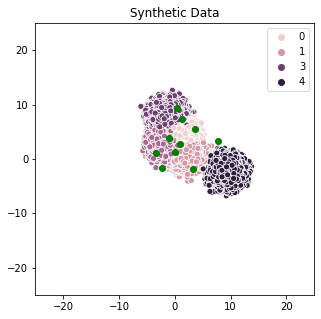

{0: (1.2983746226561381, 7.421486570684006),
 1: (3.2588207934681206, -1.7924977591125124),
 2: (-3.407574999665517, 1.0452329952641852),
 3: (0.9499499414200734, 2.8233166607814586),
 4: (-2.326144735330165, -1.6955732256118896),
 5: (-1.1083928691426388, 3.774521611430313),
 6: (0.3929185559252002, 9.431127939401742),
 7: (0.061248686715265066, 1.184925520552506),
 8: (3.5938142946046323, 5.541378376946369),
 9: (7.716264541920196, 3.2659131736501)}

In [15]:
from sklearn.datasets import make_blobs
from sklearn.datasets import make_classification
import random

# Generate Imbalanced Synthetic Data
# X,y = make_classification(n_samples=800000, n_classes=2,shift=4 ,n_informative=4, n_redundant=0,n_repeated=0, n_clusters_per_class=2,class_sep=.8,flip_y=0,weights=[0.85,.15], random_state=55)
X, y = make_blobs(n_samples=800000, centers=int(groups), n_features=2, random_state=0)
# create dataframe to hold x and y coordinates
df = pd.DataFrame({
    'x_coord': X[:,0],
    'y_coord': X[:,1]})
df['group'] = y

 
#arbitrarily picked random k (number of centroids)
k = int(centroids)
centroids = {}
#randomly initialized centroid x and y coordinates (in real data we will actually have these coordinates)
for i in range(k):
  centroids[i] = ((random.choice(X[:,0])), (random.choice(X[:,1])))

#colors for centroids
color_map = {}
for i in range(k):
  color_map[i] = 'g'

#plot synthetic data
fig = plt.figure(figsize=(5,5))
ax = sns.scatterplot(X[:,0],X[:,1],hue=y)

for i in centroids.keys():
  plt.scatter(centroids[i][0], centroids[i][1], color=color_map[i])
df = assign_cluster(df, centroids)
df
plt.xlim(-25, 25)
plt.ylim(-25, 25)
ax.set_title("Synthetic Data")
plt.show()

centroids

Time elapsed Assignment Step:  2.3165276050567627


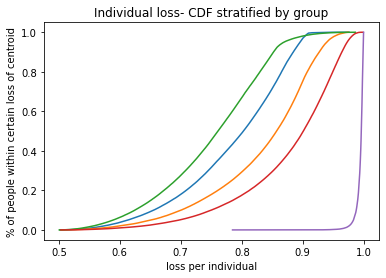

max perc  0.9960923594222517  ind  4
indiv loss  0.7252476914881315
subgroup loss:  0.2350584255326581
XXX
Time elapsed Batch Step:  0.013152599334716797
Time elapsed Assignment Step:  2.2776591777801514
max perc  0.9999168875317137  ind  4
indiv loss  0.7725087535709111
subgroup loss:  0.0813029233311201
iteration number:  1
old loss:  0.07252476914881316
temp loss:  0.07725087535709112
XXX
Time elapsed Batch Step:  0.013571500778198242
Time elapsed Assignment Step:  2.215388536453247
max perc  0.9999319155391592  ind  4
indiv loss  0.7889998657368718
subgroup loss:  0.0802609670462342
iteration number:  2
old loss:  0.07252476914881316
temp loss:  0.07889998657368719
XXX
Time elapsed Batch Step:  0.013066768646240234
Time elapsed Assignment Step:  2.218942642211914
max perc  0.9999323424971165  ind  4
indiv loss  0.7890459686723708
subgroup loss:  0.07883933706742985
iteration number:  3
old loss:  0.07252476914881316
temp loss:  0.07890459686723708
XXX
Time elapsed Batch Step:  0.01

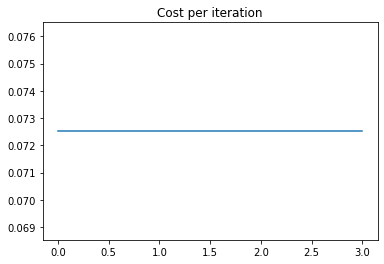

{0: (1.2983746226561381, 7.421486570684006),
 1: (3.2588207934681206, -1.7924977591125124),
 2: (-3.407574999665517, 1.0452329952641852),
 3: (0.9499499414200734, 2.8233166607814586),
 4: (-2.326144735330165, -1.6955732256118896),
 5: (-1.1083928691426388, 3.774521611430313),
 6: (0.3929185559252002, 9.431127939401742),
 7: (0.061248686715265066, 1.184925520552506),
 8: (3.5938142946046323, 5.541378376946369),
 9: (7.716264541920196, 3.2659131736501)}

In [16]:
df = assign_cluster(df, centroids)
groups = compute_groups(df)
compute_cdf_graph(groups)
clusters = compute_clusters(df)
cdf1, cdf2 = compute_cdf(groups)
#subgroup loss between max and min loss
subgroup_loss = compare_loss(groups[cdf1], groups[cdf2], 50)
loss = sum_loss(df, centroids, subgroup_loss)
update(.7, centroids,df, subgroup_loss, loss, groups, cdf1, cdf2)

In [17]:
centroids 

{0: (1.2983746226561381, 7.421486570684006),
 1: (3.2588207934681206, -1.7924977591125124),
 2: (-3.407574999665517, 1.0452329952641852),
 3: (0.9499499414200734, 2.8233166607814586),
 4: (-2.326144735330165, -1.6955732256118896),
 5: (-1.1083928691426388, 3.774521611430313),
 6: (0.3929185559252002, 9.431127939401742),
 7: (0.061248686715265066, 1.184925520552506),
 8: (3.5938142946046323, 5.541378376946369),
 9: (7.716264541920196, 3.2659131736501)}

In [18]:
df.head(30)

,x_coord,y_coord,group,dist_from_1,dist_from_3,dist_from_4,dist_from_7,min_centr,min_loss,dist_from_8,dist_from_5,dist_from_6
0,-0.688103,7.193609,3,7.240763,7.251528,9.038846,7.226979,7,0.999274,7.232937,7.229555,7.227697
1,0.194312,4.575750,0,4.593687,4.605247,6.758861,4.580987,7,0.989859,4.587060,4.582515,4.581253
2,1.405993,4.042057,0,4.291501,4.304014,6.844651,4.281862,5,0.986361,4.287799,4.281100,4.281165
3,-0.456957,8.746674,3,8.772791,8.783828,10.608222,8.759319,7,0.999843,8.765326,8.761571,8.759897
4,9.563979,-2.428965,4,9.860230,9.862790,11.912720,9.871413,1,0.999948,9.870586,9.863536,9.868124
5,-1.222979,8.719533,3,8.819306,8.829773,10.473367,8.805229,7,0.999850,8.811127,8.808130,8.806089
6,-0.846731,7.283136,3,7.346562,7.357191,9.099773,7.332639,7,0.999347,7.338571,7.335366,7.333423
7,-1.391837,6.850959,3,7.005435,7.015456,8.597450,6.990999,7,0.999081,6.996794,6.994341,6.992053
8,1.981638,3.415283,0,3.958632,3.971202,6.684149,3.951453,5,0.981095,3.957026,3.949217,3.950153
9,1.476222,4.437901,0,4.688992,4.701484,7.216474,4.679191,5,0.990793,4.685145,4.678535,4.678538


In [19]:
df = assign_cluster(df, centroids)
df

Time elapsed Assignment Step:  2.2536685466766357


,x_coord,y_coord,group,dist_from_1,dist_from_3,dist_from_4,dist_from_7,min_centr,min_loss,dist_from_8,dist_from_5,dist_from_6,dist_from_0,dist_from_2,dist_from_9
0,-0.688103,7.193609,3,9.814699,4.667191,9.038846,6.055229,0,0.880745,4.589628,3.444822,2.484975,1.999505,6.722950,9.276863
1,0.194312,4.575750,0,7.067234,1.908406,6.758861,3.393434,5,0.821916,3.533986,1.529381,4.859438,3.052404,5.043624,7.635145
2,1.405993,4.042057,0,6.121683,1.301270,6.844651,3.157774,3,0.786049,2.652268,2.528578,5.483466,3.381142,5.670219,6.357825
3,-0.456957,8.746674,3,11.175023,6.088148,10.608222,7.579484,6,0.748612,5.165526,5.014645,1.091222,2.199388,8.247323,9.840746
4,9.563979,-2.428965,4,6.337200,10.089002,11.912720,10.166714,9,0.997495,9.958375,12.344341,14.992336,12.858911,13.428747,5.987126
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
799995,1.954802,4.651530,0,6.574645,2.086167,7.655862,3.950050,8,0.865878,1.864991,3.186269,5.028324,2.846675,6.462234,5.925739
799996,-0.864044,9.435572,3,11.961085,6.856566,11.226759,8.302369,6,0.778504,5.919227,5.666321,1.256970,2.955096,8.767402,10.568178
799997,9.480259,-2.934193,4,6.325327,10.291506,11.871199,10.280316,1,0.998213,10.319184,12.535007,15.345388,13.197854,13.488221,6.446161
799998,-0.706814,8.844517,3,11.352196,6.244976,10.663758,7.698004,6,0.776677,5.422742,5.085875,1.246405,2.458820,8.253662,10.102924
